<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W1D5/tutorials/W1D5-DimensionalityReduction/W1D5-Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neuromatch Academy: Week 1, Day 5, Tutorial 3
# Dimensionality Reduction and reconstruction

---

In this notebook we'll learn to apply PCA for dimensionality reduction, using a classic dataset that is often used to benchmark machine learning algorithms: the MNIST dataset of handwritten digits. We'll also learn how to use PCA for reconstruction and denoising.

Steps:
 1. Perform PCA on MNIST dataset.
 2. Calculate the variance explained.
 3. Reconstruct data with different numbers of PCs.
 4. Examine denoising using PCA.

To learn more about MNIST: 
* https://en.wikipedia.org/wiki/MNIST_database

---

Video available at https://youtube.com/watch?v=ew0-P7-6Nho


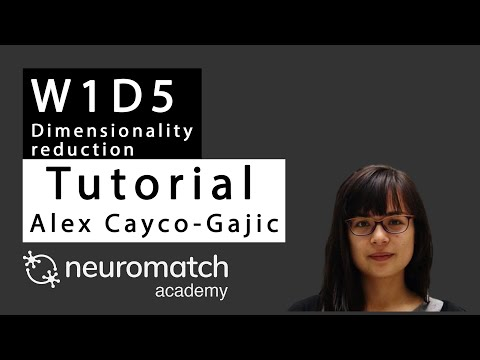

In [85]:
#@title Video: Logistic regression
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ew0-P7-6Nho", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


# Setup
Run these cells to get the tutorial started.

In [86]:
#import libraries
import time                        # import time 
import numpy as np                 # import numpy
import scipy as sp                 # import scipy
import math                        # import basic math 
import random                      # import basic random number generator functions

import matplotlib.pyplot as plt    # import matplotlib
from IPython import display   

In [87]:
# @title Figure Settings
fig_w, fig_h = (10, 4)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [88]:
# @title Helper Functions
# New helper functions

def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.
  
  Args:
     variance_explained (numpy array of floats) : Vector of variance explained for each PC
     
  Returns: 
    Nothing.
    
  """
  plt.figure()
  plt.plot(np.arange(1,len(variance_explained)+1),variance_explained,'o-k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')

def plot_MNIST_reconstruction(X,X_reconstructed):
  """
  Plots 9 images in the MNIST dataset side-by-side with the reconstructed images.
  
  Args:
     X (numpy array of floats):   Data matrix 
                                  each column corresponds to a different random variable 
     X_reconstructed (numpy array of floats):   Data matrix 
                                  each column corresponds to a different random variable 
    
  Returns: 
    Nothing.
    
  """
  plt.figure()
  ax = plt.subplot(1,2,1)
  k=0
  for k1 in range(3):
    for k2 in range(3):
      k = k+1
      plt.imshow(np.reshape(X[k,:],(28,28)),extent=[(k1+1)*28,k1*28,(k2+1)*28,k2*28],vmin=0,vmax=255)
  plt.xlim((3*28,0))
  plt.ylim((3*28,0))
  plt.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([]) 
  plt.title('Data')
  plt.clim([0,250])
  ax = plt.subplot(1,2,2)
  k=0
  for k1 in range(3):
    for k2 in range(3):
      k = k+1
      plt.imshow(np.real(np.reshape(X_reconstructed[k,:],(28,28))),extent=[(k1+1)*28,k1*28,(k2+1)*28,k2*28],vmin=0,vmax=255)
  plt.xlim((3*28,0))
  plt.ylim((3*28,0))
  plt.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([]) 
  plt.clim([0,250])
  plt.title('Reconstructed')


def plot_MNIST_sample(X):
  """
  Plots 9 images in the MNIST dataset.
  
  Args:
     X (numpy array of floats):   Data matrix 
                                  each column corresponds to a different random variable 

  Returns: 
    Nothing.
    
  """
  plt.figure()
  fig, ax = plt.subplots()
  k=0
  for k1 in range(3):
    for k2 in range(3):
      k = k+1
      plt.imshow(np.reshape(X[k,:],(28,28)),extent=[(k1+1)*28,k1*28,(k2+1)*28,k2*28],vmin=0,vmax=255)
  plt.xlim((3*28,0))
  plt.ylim((3*28,0))
  plt.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False)
  plt.clim([0,250])
  ax.set_xticks([])
  ax.set_yticks([])

def plot_MNIST_weights(weights):
  """
  Visualize PCA basis vector weights for MNIST. Red = positive weights, blue = 
  negative weights, white = zero weight.
  
  Args:
     weights (numpy array of floats) : PCA basis vector
     
  Returns: 
     Nothing.
    
  """
  plt.figure()
  fig, ax = plt.subplots()
  cmap = plt.cm.get_cmap('seismic')
  plt.imshow(np.real(np.reshape(weights,(28,28))),cmap=cmap)
  plt.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False)
  plt.clim(-.15,.15)
  plt.colorbar(ticks=[-.15,-.1,-.05,0,.05,.1,.15])
  ax.set_xticks([])
  ax.set_yticks([])

def add_noise(X,frac_noisy_pixels):
  """
  Randomly corrupts a fraction of the pixels by setting them to random values.
  
  Args:
     X (numpy array of floats) : Data matrix
     frac_noisy_pixels (scalar) : Fraction of noisy pixels
     
  Returns: 
     (numpy array of floats) : Data matrix + noise
    
  """
  X_noisy = np.reshape(X,(X.shape[0]*X.shape[1]))
  N_noise_ixs = int(X_noisy.shape[0] * frac_noisy_pixels)
  noise_ixs = np.random.choice(X_noisy.shape[0],size= N_noise_ixs,replace=False)
  X_noisy[noise_ixs] = np.random.uniform(0,255,noise_ixs.shape)
  X_noisy = np.reshape(X_noisy,(X.shape[0],X.shape[1]))
  return X_noisy



  # Old helper functions from Tutorial 1-2

def change_of_basis(X,W):
  """
  Projects data onto a new basis.
  
  Args:
    X (numpy array of floats) : Data matrix
                                each column corresponding to a different random variable
    W (numpy array of floats):  new orthonormal basis
                                columns correspond to basis vectors
  
  Returns: 
    (numpy array of floats) : Data matrix expressed in new basis
  """
  Y = np.matmul(X,W)
  return Y

def get_sample_cov_matrix(X):
  """
    Returns the sample covariance matrix of data X
    
    Args:
      X (numpy array of floats):   Data matrix 
                                  each column corresponds to a different random variable 
      
    Returns: 
      (numpy array of floats) : Covariance matrix
  """
  X = X - np.mean(X,0)
  cov_matrix = 1./X.shape[0]*np.matmul(X.T,X)
  return cov_matrix

def sort_evals_descending(evals,evectors):
  """  
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats):   Vector of eigenvalues 
    evectors (numpy array of floats):   Corresponding matrix of eigenvectors 
                                each column corresponds to a different eigenvalue 
    
  Returns: 
    (numpy array of floats) : Vector of eigenvalues after sorting
    (numpy array of floats) : Matrix of eigenvectors after sorting
  """
  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:,index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:,0], 1./np.sqrt(2)*np.array([1,1]))) > np.pi/2.:
      evectors[:,0] = -evectors[:,0]
    if np.arccos(np.matmul(evectors[:,1], 1./np.sqrt(2)*np.array([-1,1]))) > np.pi/2.:
      evectors[:,1] = -evectors[:,1]
  return evals, evectors

def pca(X):
  """
  Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order.
  
  Args:
     X (numpy array of floats):   Data matrix 
                                  each column corresponds to a different random variable 
     
  Returns: 
    (numpy array of floats) : Data projected onto the new basis
    (numpy array of floats) : Vector of eigenvalues
    (numpy array of floats) : Corresponding matrix of eigenvectors 
    
  """
  X = X - np.mean(X,0)
  cov_matrix = get_sample_cov_matrix(X)
  evals, evectors = np.linalg.eig(cov_matrix)
  evals, evectors = sort_evals_descending(evals,evectors)
  score = change_of_basis(X,evectors)
  return score, evectors, evals

def plot_eigenvalues(evals):
  """
  Plots eigenvalues.
  
  Args:
     (numpy array of floats) : Vector of eigenvalues
     
  Returns: 
    Nothing.
    
  """
  plt.figure()
  plt.plot(np.arange(1,len(evals)+1),evals,'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')

# Perform PCA on MNIST dataset.
The MNIST dataset consists of a 70,000 images of individual handwritten digits. Each image is a 28x28 pixel grayscale image. For convenience, each 28x28 pixel image is often unravelled into a single 784 (=28*28) element vector, so that the whole dataset is represented as a 70,000 x 784 matrix. Each row represents a different image, and each column represents a different pixel.
 
Enter the following cell to load the MNIST dataset and plot the first nine images.

<Figure size 432x288 with 0 Axes>

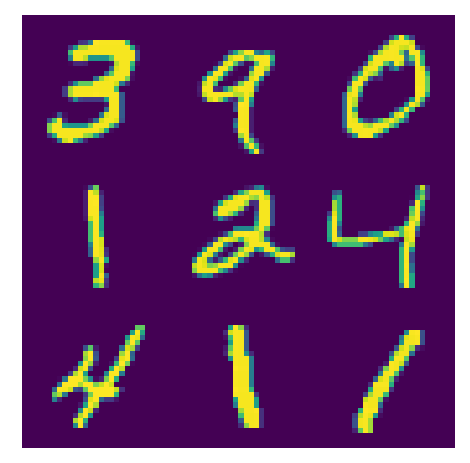

In [89]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name = 'mnist_784')
X = mnist.data
plot_MNIST_sample(X)


The MNIST dataset has an extrinsic dimensionality of 784, much higher than the 2-dimensional examples used in the previous tutorials! To make sense of this data, we'll use dimensionality reduction. But first, we need to determine the intrinsic dimensionality $K$ of the data. One way to do this is to look for an "elbow" in the scree plot, to determine which eigenvalues are signficant.

#### Exercise
In this exercise you will examine the scree plot in the MNIST dataset.

**Suggestions**
* Perform PCA on the dataset and examine the scree plot. 
* When do the eigenvalues appear (by eye) to reach zero? (Hint: use `plt.xlim` to zoom into a section of the plot).


In [90]:
help(pca)
help(plot_eigenvalues)

Help on function pca in module __main__:

pca(X)
    Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order.
    
    Args:
       X (numpy array of floats):   Data matrix 
                                    each column corresponds to a different random variable 
       
    Returns: 
      (numpy array of floats) : Data projected onto the new basis
      (numpy array of floats) : Vector of eigenvalues
      (numpy array of floats) : Corresponding matrix of eigenvectors

Help on function plot_eigenvalues in module __main__:

plot_eigenvalues(evals)
    Plots eigenvalues.
    
    Args:
       (numpy array of floats) : Vector of eigenvalues
       
    Returns: 
      Nothing.



In [91]:
###################################################################
## Insert your code here to:
##                perform PCA 
##                plot the eigenvalues
################################################################### 

# score, evectors, evals = ...YOUR CODE HERE to perform PCA
# plot_eigenvalues(evals)
# YOUR CODE HERE to limit the x-axis for zooming

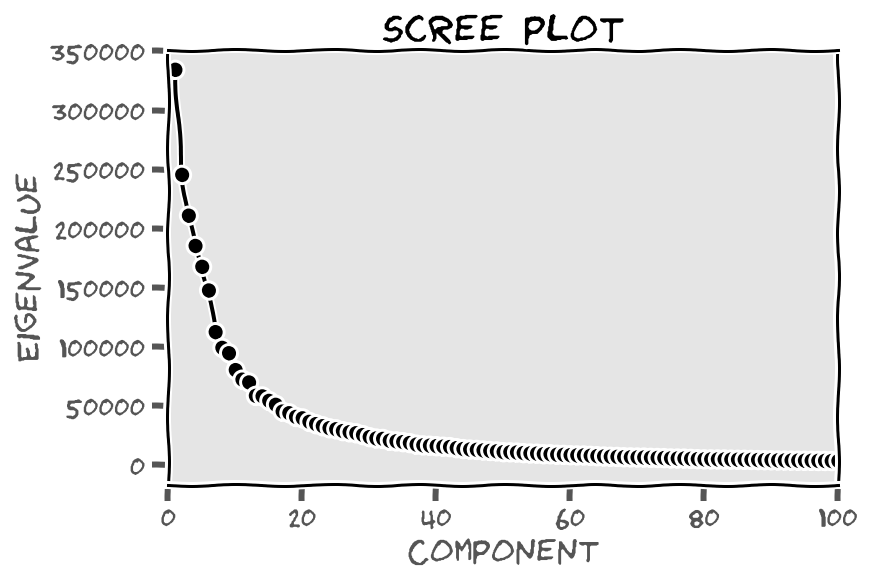

In [92]:
# to_remove solution
score, evectors, evals = pca(X)

with plt.xkcd():
  plot_eigenvalues(evals)
  plt.xlim([0,100])

# Calculate the variance explained.
The scree plot suggests that most of the eigenvalues are near zero, with fewer than 100 having large values. Another common way to determine the intrinsic dimensionality is by considering the   variance explained. This can be examined with a cumulative plot of the fraction of the total variance explained by the top $K$ components, i.e.:
\begin{equation}
\text{var explained} = \frac{\sum_{i=1}^K \lambda_i}{\sum_{i=1}^N \lambda_i}
\end{equation}
The intrinsic dimensionality is often quantified by the $K$ necessary to explain a large proportion of the total variance of the data (often a defined threshold, e.g., 90%).


#### Exercise
In this exercise you will plot the explained variance.

**Suggestions**
* Fill in the function below to calculate the fraction variance explained as a function of the number of principal componenets. **Hint:** use `np.cumsum`.
* Plot the variance explained using `plot_variance_explained`.
* How many principal components are required to explain 90% of the variance?
* How does the intrinsic dimensionality of this dataset compare to its extrinsic dimensionality?


In [93]:
help(plot_variance_explained)

Help on function plot_variance_explained in module __main__:

plot_variance_explained(variance_explained)
    Plots eigenvalues.
    
    Args:
       variance_explained (numpy array of floats) : Vector of variance explained for each PC
       
    Returns: 
      Nothing.



In [94]:
def get_variance_explained(evals):
  """
  Calculates variance explained from the eigenvalues.
  
  Args:
     evals (numpy array of floats) : Vector of eigenvalues
     
  Returns: 
    (numpy array of floats) : Vector of variance explained
    
  """
  ###################################################################
  ## Insert your code here to:
  ##                cumulatively sum the eigenvalues
  ##                normalize by the sum of eigenvalues

  #uncomment once you've filled in the function
  raise NotImplementedError("Student excercise: calculate explaine variance!")
  ################################################################### 
  return variance_explained

###################################################################
## Insert your code here to:
##                calculate and plot the variance explained 
################################################################### 
# variance_explained = ...
# plot_variance_explained(variance_explained)

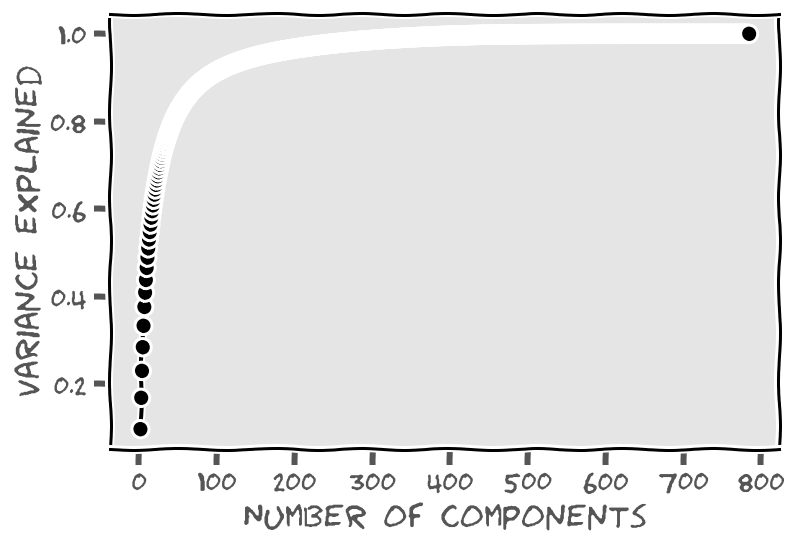

In [95]:
# to_remove solution

def get_variance_explained(evals):
  """
  Plots eigenvalues.
  
  Args:
     (numpy array of floats) : Vector of eigenvalues
     
  Returns: 
    Nothing.
    
  """
  return np.cumsum(evals)/np.sum(evals)
  
variance_explained = get_variance_explained(evals)

with plt.xkcd():
  plot_variance_explained(variance_explained)

# Reconstruct data with different numbers of PCs.


Video available at https://youtube.com/watch?v=A_a7_hMhjfc


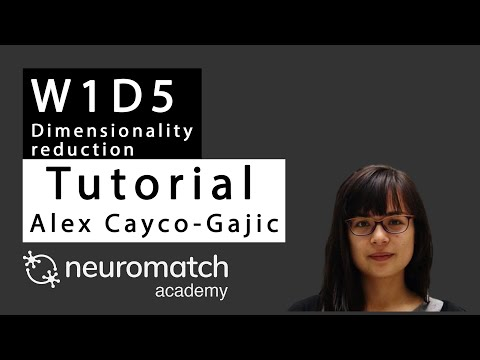

In [96]:
#@title Video: Geometric view of data
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="A_a7_hMhjfc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


Now we have seen that the top 100 or so principal components of the data can explain most of the variance. We can use this fact to perform *dimensionality reduction*, i.e., by storing the data using only 100 components rather than the samples of all 784 pixels. Remarkably, we will be able to reconstruct much of the structure of the data using only the top 100 components. To see this, recall that to perform PCA we projected the data $\bf X$ onto the eigenvectors of the covariance matrix:
\begin{equation}
\bf S = X W
\end{equation}
Since $\bf W$ is an orthogonal matrix, ${\bf W}^{-1} = {\bf W}^T$. So by multiplying by ${\bf W}^T$ on each side we can rewrite this equation as  
\begin{equation}
{\bf X = S W}^T.
\end{equation}
This now gives us a way to reconstruct the data matrix from the scores and loadings. To reconstruct the data from a low-dimensional approximation, we just have to truncate these matrices.  Let's call ${\bf S}_{1:K}$ and ${\bf W}_{1:K}$ as keeping only the first $K$ columns of this matrix. Then our reconstruction is:
\begin{equation}
{\bf \hat X = S}_{1:K} ({\bf W}_{1:K})^T.
\end{equation}

#### Exercise
Fill in the function below to reconstruct the data using different numbers of principal components. 

**Suggestions**
* Fill in the following function to reconstruct the data based on the weights and scores. Don't forget to add the mean!
* Make sure your function works by reconstructing the data with all $K=784$ components. They two images should look identical.

In [97]:
help(plot_MNIST_reconstruction)

Help on function plot_MNIST_reconstruction in module __main__:

plot_MNIST_reconstruction(X, X_reconstructed)
    Plots 9 images in the MNIST dataset side-by-side with the reconstructed images.
    
    Args:
       X (numpy array of floats):   Data matrix 
                                    each column corresponds to a different random variable 
       X_reconstructed (numpy array of floats):   Data matrix 
                                    each column corresponds to a different random variable 
      
    Returns: 
      Nothing.



In [98]:
def reconstruct_data(score,evectors,X_mean,K):
  """
  Reconstruct the data based on the top K components.
  
  Args:
     score (numpy array of floats) : Score matrix
     evectors (numpy array of floats) : Matrix of eigenvectors
     X_mean (numpy array of floats) : Vector corresponding to data mean
     K (scalar) : Number of components to include
     
  Returns: 
     (numpy array of floats) : Matrix of reconstructed data 
    
  """
  ###################################################################
  ## Insert your code here to:
  ##                Reconstruct the data from the score and eigenvectors
  ##                Don't forget to add the mean!!

  #X_reconstructed =  Your code here 
  #uncomment once you've filled in the function
  raise NotImplementedError("Student excercise: finish reconstructing data function!")
  ################################################################### 
  return X_reconstructed

K = 784

## Uncomment below to to:
##                Reconstruct the data based on all components
##                Plot the data and reconstruction
# X_mean = ...
# X_reconstructed = ...
# plot_MNIST_reconstruction(X ,X_reconstructed)


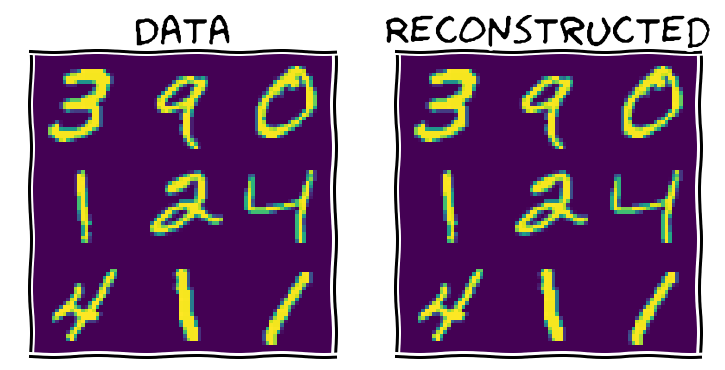

In [99]:
# to_remove solution

def reconstruct_data(score,evectors,X_mean,K):
  """
  Reconstruct the data based on the top K components.
  
  Args:
     score (numpy array of floats) : Score matrix
     evectors (numpy array of floats) : Matrix of eigenvectors
     X_mean (numpy array of floats) : Vector corresponding to data mean
     K (scalar) : Number of components to include
     
  Returns: 
     (numpy array of floats) : Matrix of reconstructed data 
    
  """
  X_reconstructed = np.matmul(score[:,:K],evectors[:,:K].T) + X_mean
  return X_reconstructed

K = 784

with plt.xkcd():
  X_mean = np.mean(X,0) 
  X_reconstructed = reconstruct_data(score,evectors,X_mean,K)
  plot_MNIST_reconstruction(X ,X_reconstructed)


#### Exercise:
Now run the code below and experiment with the slider to reconstruct the data matrix using different numbers of principal components.

**Questions:**
* How many principal components are necessary to reconstruct the numbers (by eye)? How does this relate to the intrinsic dimensionality of the data?
* Do you see any information in the data with only a single principal component?

In [100]:
###### MAKE SURE TO RUN THIS CELL VIA THE PLAY BUTTON TO ENABLE SLIDERS ########

import ipywidgets as widgets

def refresh(K = 100):
  X_reconstructed = reconstruct_data(score,evectors,X_mean,K)
  plot_MNIST_reconstruction(X ,X_reconstructed)
  plt.title('Reconstructed, K={}'.format(K))

_ = widgets.interact(refresh, 
  K = (1, 784, 10))

interactive(children=(IntSlider(value=100, description='K', max=784, min=1, step=10), Output()), _dom_classes=…

#### Exercise:
Next, let's take a closer look at the first principal component by visualizing its corresponding weights. 

**Questions**
* Enter `plot_MNIST_weights` to visualize the weights of the first basis vector.
* What structure do you see? Which pixels have a strong positive weighting? Which have a strong negative weighting? What kinds of images would this basis vector differentiate?
* Try visualizing the second and third basis vectors. Do you see any structure? What about the 100th basis vector? 500th? 700th?

In [101]:
help(plot_MNIST_weights)

Help on function plot_MNIST_weights in module __main__:

plot_MNIST_weights(weights)
    Visualize PCA basis vector weights for MNIST. Red = positive weights, blue = 
    negative weights, white = zero weight.
    
    Args:
       weights (numpy array of floats) : PCA basis vector
       
    Returns: 
       Nothing.



In [102]:
###################################################################
## Insert your code here to:
##                Plot the weights of the first principal component

#plot_MNIST_weights(Your code here)
################################################################### 

<Figure size 432x288 with 0 Axes>

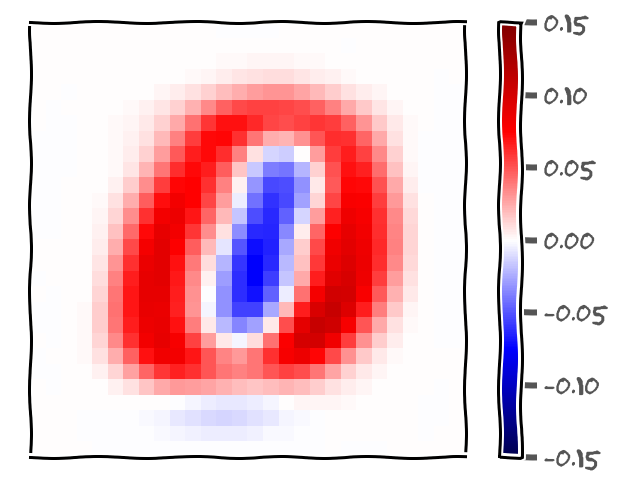

In [103]:
# to_remove solution
with plt.xkcd():
  plot_MNIST_weights(evectors[:,0])
  plt.show()

# (Optional Exploration): Examine denoising using PCA.
   
Finally, we will test how PCA can be used to denoise data. We will add salt-and-pepper noise to the original data and see how that affects the eigenvalues. To do this, we'll use the function `add_noise`, starting with adding noise to 20% of the pixels.
The we'll Perform PCA and plot the variance explained. How many principal components are required to explain 90% of the variance? How does this compare to the original data?



<Figure size 432x288 with 0 Axes>

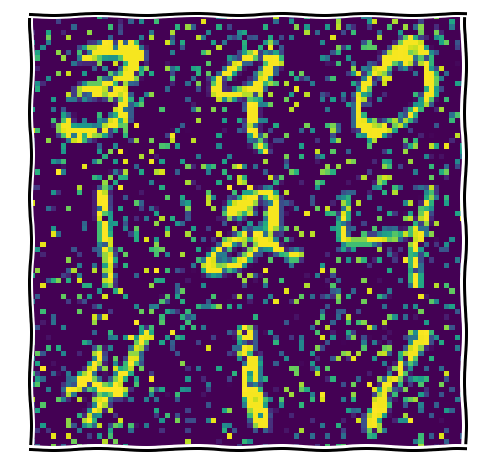

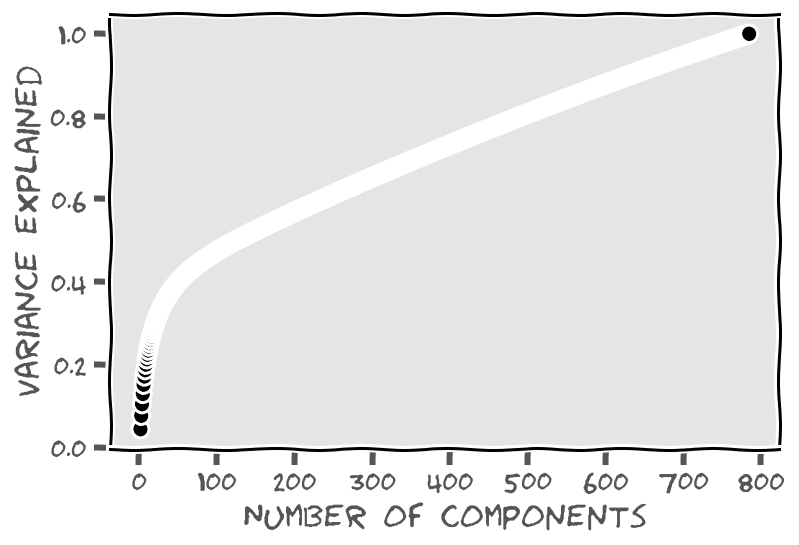

In [104]:
###################################################################
## Here we:
##                Add noise to the data
##                Plot noise-corrupted data
##                Perform PCA on the noisy data
##                Calculate and plot the variance explained
################################################################### 
X_noisy = add_noise(X,.2)
score_noisy, evectors_noisy, evals_noisy = pca(X_noisy)
variance_explained_noisy = get_variance_explained(evals_noisy)

with plt.xkcd():
  plot_MNIST_sample(X_noisy)
  plot_variance_explained(variance_explained_noisy)


To denoise the data, we can simply project it onto the basis found with the original dataset (`evectors`, not `evectors_noisy`). Then, by taking the top K components of this projection, we have a guess for where the sample should lie in the K-dimensional latent space. We can then reconstruct the data as normal, using the top 50 components. You should play around with the amount of noise and K to build intuition.


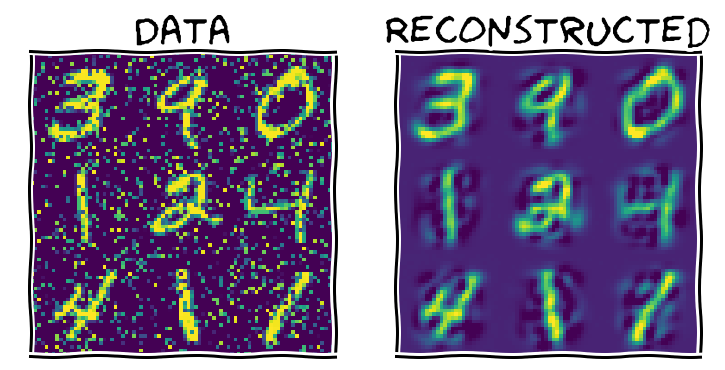

In [105]:
###################################################################
## Here we:
##                Subtract the mean of the noise-corrupted data
##                Project onto the original basis vectors evectors
##                Reconstruct the data using the top 50 components
##                Plot the result
################################################################### 

X_noisy_mean = np.mean(X_noisy,0)
projX_noisy = np.matmul(X_noisy-X_noisy_mean,evectors)
X_reconstructed = reconstruct_data(projX_noisy,evectors,X_noisy_mean,50)

with plt.xkcd():
  plot_MNIST_reconstruction(X_noisy,X_reconstructed)